In [1]:
import proglearn
from proglearn.forest import UncertaintyForest
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        #vote_indices = unsampled_indices[:total_unsampled//2]
        #eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        vote_classes = y[unsampled_indices ]
        
        #est_nodes = tree.apply(X[vote_indices])
        #est_classes = y[vote_indices]
        for i in range(len(vote_nodes)):
            class_counts[vote_nodes[i], vote_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        vote_class_probs = class_probs[vote_nodes]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        vote_entropies = [entropy(posterior) for posterior in vote_class_probs]
        cond_entropy += np.mean(vote_entropies)
      
    return cond_entropy / n_estimators

In [3]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [4]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

In [5]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [6]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [7]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

In [8]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left")
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [10]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [11]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return uf(X, y, base = np.exp(1), kappa = 3)
    else:
        raise ValueError("Unrecognized Label!")

In [12]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [13]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 20
n1 = 3000
n2 = 6000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(300, 1201, 90)
sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2
# num_plotted_trials = 2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [14]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.17271257, 0.14954203, 0.13310031, 0.14601311, 0.13764862,
         0.17546971, 0.10330947, 0.16131851, 0.13397028, 0.15247513,
         0.08047888, 0.14231824, 0.10571029, 0.09810133, 0.12936363,
         0.07963576, 0.14413493, 0.14405336, 0.13382067, 0.15056666],
        [0.14671852, 0.15203859, 0.12700358, 0.16228855, 0.09572335,
         0.10081937, 0.14987058, 0.09870162, 0.11947187, 0.10490945,
         0.14442733, 0.13696644, 0.12044341, 0.14042576, 0.14398853,
         0.11957225, 0.14603538, 0.14074013, 0.16254614, 0.14375962],
        [0.13251212, 0.10991713, 0.13775503, 0.15911186, 0.10791581,
         0.12809727, 0.13926515, 0.16506231, 0.14597112, 0.11844314,
         0.14149753, 0.135302  , 0.17209127, 0.12890662, 0.11792237,
         0.1363695 , 0.14845078, 0.14119394, 0.12497029, 0.12476331],
        [0.11926039, 0.12476467, 0.16210801, 0.12344632, 0.13308409,
         0.14442636, 0.13169226, 0.13063657, 0.11477547, 0.13130367,
         0.13787127, 0.11953945

In [15]:
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[2.71575940e-01, 2.61858643e-01, 2.81741178e-01, 2.81098697e-01,
         2.75349604e-01, 2.75517908e-01, 2.89448932e-01, 2.77313510e-01,
         2.76639822e-01, 2.80136936e-01, 2.78420802e-01, 2.98009301e-01,
         2.79190978e-01, 2.64905685e-01, 2.76685067e-01, 2.91605215e-01,
         2.84969857e-01, 2.69761519e-01, 2.86507017e-01, 2.69844946e-01],
        [1.19808267e-01, 1.30978342e-01, 1.41004370e-01, 1.37176549e-01,
         1.40300862e-01, 1.35925275e-01, 1.23599337e-01, 1.35964971e-01,
         1.30441975e-01, 1.31130235e-01, 1.43841683e-01, 1.24673234e-01,
         1.30764585e-01, 1.22667789e-01, 1.35913570e-01, 1.30639860e-01,
         1.37261542e-01, 1.28151722e-01, 1.32430145e-01, 1.14185603e-01],
        [5.25719116e-02, 4.51631384e-02, 4.94426396e-02, 5.49251066e-02,
         5.46417387e-02, 5.42791269e-02, 5.35102514e-02, 5.87204482e-02,
         4.64917795e-02, 5.76416896e-02, 4.91243437e-02, 4.98974846e-02,
         5.87815620e-02, 5.76978827e-02, 5.686906

In [16]:
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.15942007, 0.22570043, 0.19063527, 0.1948111 , 0.19669698,
         0.1998208 , 0.20275073, 0.20807053, 0.21889877, 0.19334924,
         0.19152965, 0.20716085, 0.1856981 , 0.20147863, 0.21088873,
         0.21185768, 0.22050938, 0.19396123, 0.17314773, 0.17109894],
        [0.17057589, 0.19094622, 0.16454755, 0.16331115, 0.19008125,
         0.16166511, 0.17113531, 0.17714167, 0.16746122, 0.16564809,
         0.18738335, 0.19037211, 0.17076736, 0.18008264, 0.21477042,
         0.15358876, 0.21321933, 0.18038984, 0.17820034, 0.16374296],
        [0.17548834, 0.17268638, 0.17407576, 0.16078023, 0.18141029,
         0.17928506, 0.16451286, 0.18181559, 0.18674768, 0.14965274,
         0.17952892, 0.19751404, 0.12386595, 0.16980869, 0.17423962,
         0.16141503, 0.18019519, 0.20326275, 0.18247002, 0.16747259],
        [0.15999645, 0.17189255, 0.1417294 , 0.16922026, 0.1847254 ,
         0.15030107, 0.16776385, 0.14111084, 0.15740442, 0.17077755,
         0.13919731, 0.16905735

In [17]:
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.04872920e-01, 3.03727586e-01, 3.11873837e-01, 3.07635108e-01,
         3.13110617e-01, 3.14138038e-01, 3.09698191e-01, 3.25898047e-01,
         3.10917958e-01, 3.25378255e-01, 3.18912536e-01, 3.10061772e-01,
         3.01778512e-01, 3.22890634e-01, 3.12887428e-01, 3.21714229e-01,
         3.00280212e-01, 3.15262677e-01, 3.19819465e-01, 3.26026847e-01],
        [1.38063377e-01, 1.33325075e-01, 1.29918448e-01, 1.41213747e-01,
         1.34287111e-01, 1.28504059e-01, 1.34066017e-01, 1.44755244e-01,
         1.33573148e-01, 1.43044162e-01, 1.29615435e-01, 1.43012112e-01,
         1.39093708e-01, 1.28898630e-01, 1.28026802e-01, 1.33411085e-01,
         1.45903991e-01, 1.39396284e-01, 1.43982124e-01, 1.38196055e-01],
        [4.86765079e-02, 4.78985385e-02, 4.76783137e-02, 4.24795175e-02,
         4.16104690e-02, 5.11432480e-02, 4.63842968e-02, 4.92849420e-02,
         5.13802207e-02, 4.82382924e-02, 4.86556919e-02, 4.97180189e-02,
         5.38168572e-02, 5.21679102e-02, 4.538773

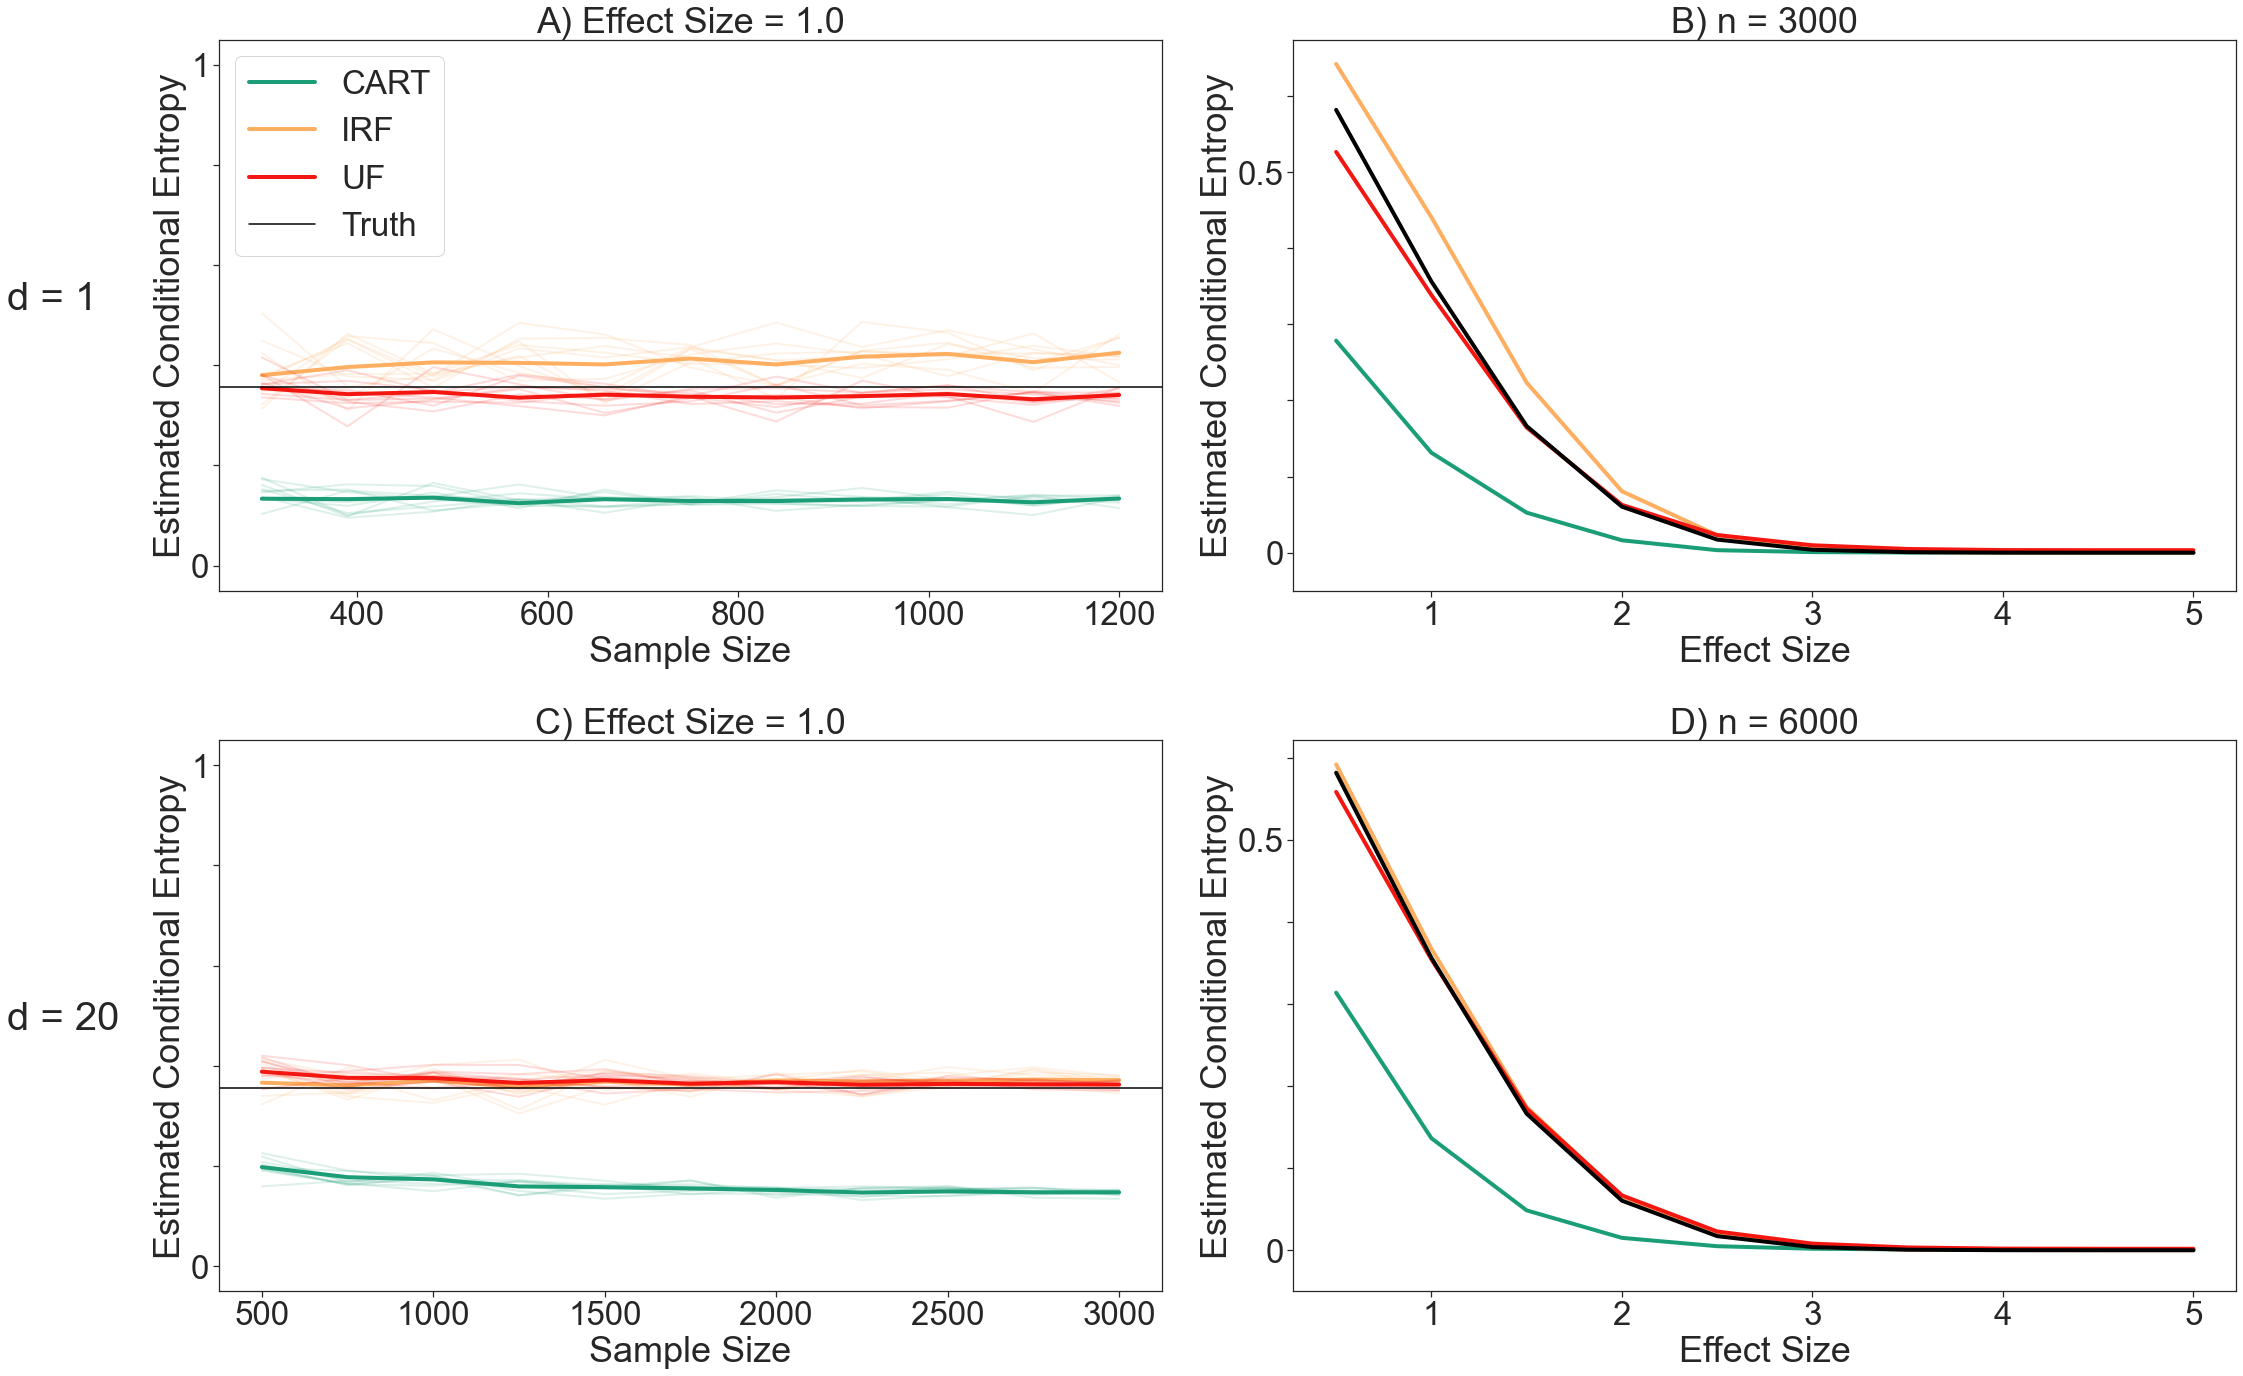

In [18]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)